In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

In [ ]:
train_image_dir = "D:\Prjs\CV\Dataset\Train\Image"
train_mask_dir = "D:\Prjs\CV\Dataset\Train\Mask"

test_image_dir = "D:\Prjs\CV\Dataset\Test\Image"

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:4: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Tien Dung\AppData\Local\Temp\ipykernel_27044\2181699262.py:1: SyntaxWarning: invalid escape sequence '\P'
  train_image_dir = "D:\Prjs\GenAI\Dataset\Train\Image"
C:\Users\Tien Dung\AppData\Local\Temp\ipykernel_27044\2181699262.py:2: SyntaxWarning: invalid escape sequence '\P'
  train_mask_dir = "D:\Prjs\GenAI\Dataset\Train\Mask"
C:\Users\Tien Dung\AppData\Local\Temp\ipykernel_27044\2181699262.py:4: SyntaxWarning: invalid escape sequence '\P'
  test_image_dir = "D:\Prjs\GenAI\Dataset\Test\Image"


Number of training images: 1087
Number of training masks: 1087


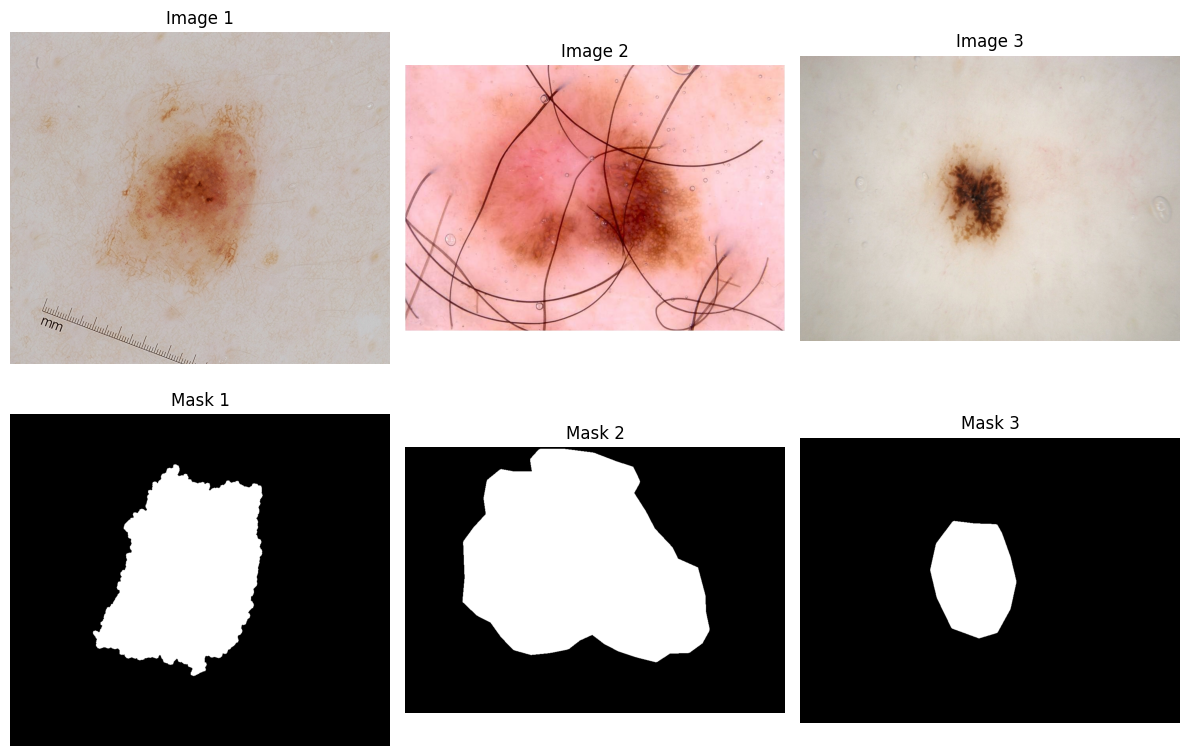

In [28]:
image_files = os.listdir(train_image_dir)
mask_files = os.listdir(train_mask_dir)

print(f"Number of training images: {len(image_files)}")
print(f"Number of training masks: {len(mask_files)}")

# Hiển thị một vài ảnh và mặt nạ
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i in range(3):
    img_path = os.path.join(train_image_dir, image_files[i])
    mask_path = os.path.join(train_mask_dir, mask_files[i])

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    axes[0, i].imshow(img, cmap="gray")
    axes[0, i].set_title(f"Image {i + 1}")
    axes[0, i].axis("off")

    axes[1, i].imshow(mask, cmap="gray")
    axes[1, i].set_title(f"Mask {i + 1}")
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()

In [29]:
def load_and_preprocess(image_dir, mask_dir, img_size=(256, 256)):
    images = []
    masks = []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        # Đọc ảnh và mặt nạ
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize ảnh và mặt nạ
        img = cv2.resize(img, img_size)
        mask = cv2.resize(mask, img_size)

        # Chuẩn hóa giá trị pixel
        img = img / 255.0  # Normalize to [0, 1]
        mask = (mask > 0).astype(np.float32)  # Binary mask

        images.append(img)
        masks.append(mask)

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    masks = np.array(masks).reshape(-1, img_size[0], img_size[1], 1)

    return images, masks

In [30]:
img_size = (256, 256)
X, Y = load_and_preprocess(train_image_dir, train_mask_dir, img_size=img_size)

print(f"X shape: {X.shape}")  # (N, H, W, 1)
print(f"Y shape: {Y.shape}")  # (N, H, W, 1)

X shape: (1087, 256, 256, 1)
Y shape: (1087, 256, 256, 1)


In [31]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_val shape: {Y_val.shape}")

X_train shape: (869, 256, 256, 1)
X_val shape: (218, 256, 256, 1)
Y_train shape: (869, 256, 256, 1)
Y_val shape: (218, 256, 256, 1)


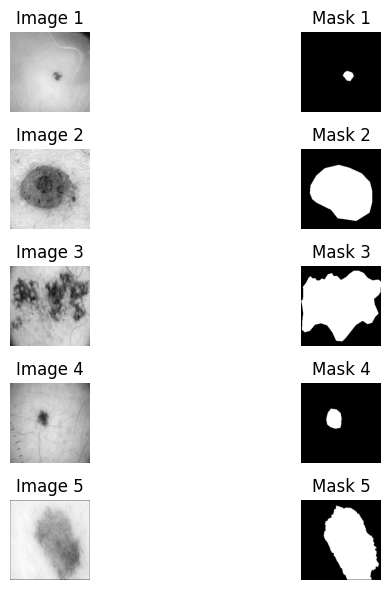

In [32]:
fig, axes = plt.subplots(5, 2, figsize=(8, 6))
for i in range(5):
    axes[i, 0].imshow(X_train[i].squeeze(), cmap="gray")
    axes[i, 0].set_title(f"Image {i + 1}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(Y_train[i].squeeze(), cmap="gray")
    axes[i, 1].set_title(f"Mask {i + 1}")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()

# Model

In [9]:
def compute_dice(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - compute_dice(y_true, y_pred)

def dice_coefficient(y_true, y_pred):
    return compute_dice(y_true, y_pred)

## FCN

In [10]:
# Convolutional block for encoder
def conv_block(inputs, filters, kernel_size=3, pool_size=2):
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(pool_size, pool_size))(x)
    return x

# Transposed convolutional block for decoder
def deconv_block(inputs, filters, kernel_size=3, strides=2):
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding='same', activation='relu')(inputs)
    return x

# FCN Model
def FCN(input_shape=(256, 256, 1), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = conv_block(inputs, 64)  # Block 1
    x = conv_block(x, 128)      # Block 2
    x = conv_block(x, 256)      # Block 3
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)  # Bottleneck

    # Decoder
    x = deconv_block(x, 256)  # Block 1
    x = deconv_block(x, 128)  # Block 2
    x = deconv_block(x, 64)   # Block 3

    # Output layer
    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs)
    return model

In [11]:
model = FCN(input_shape=(256, 256, 1), num_classes=1)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 128)  │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 1)    │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,098,625 (11.82 MB)

 Trainable params: 3,098,625 (11.82 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', dice_coefficient])
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=2, batch_size=16)

Epoch 1/2
55/55 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - accuracy: 0.3164 - dice_coefficient: 0.4046 - loss: 0.5953 - val_accuracy: 0.2558 - val_dice_coefficient: 0.4053 - val_loss: 0.5943
Epoch 2/2
55/55 ━━━━━━━━━━━━━━━━━━━━ 255s 5s/step - accuracy: 0.2807 - dice_coefficient: 0.4364 - loss: 0.5636 - val_accuracy: 0.2558 - val_dice_coefficient: 0.4053 - val_loss: 0.5943


In [ ]:
results = model.evaluate(X_val, Y_val, batch_size=16)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Dice Coefficient: {results[2]:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.3819 - dice_coefficient: 0.3389 - loss: 0.6611
Validation Loss: 0.6635
Validation Dice Coefficient: 0.3363


In [14]:
predictions = model.predict(X_val)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


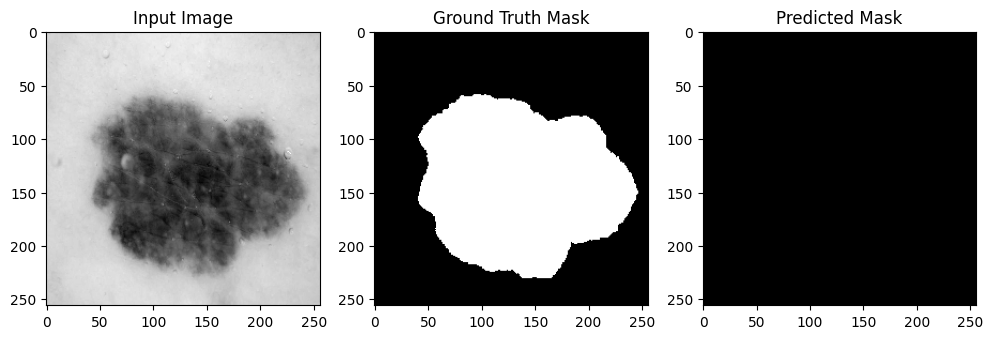

In [22]:
# Hiển thị một ảnh và mặt nạ thực tế cùng với dự đoán của mô hình
index = 50  # Chọn chỉ số của một ảnh trong tập validation
plt.figure(figsize=(12, 6))

# Ảnh gốc
plt.subplot(1, 3, 1)
plt.imshow(X_val[index].squeeze(), cmap='gray')
plt.title("Input Image")

# Mặt nạ thực tế
plt.subplot(1, 3, 2)
plt.imshow(Y_val[index].squeeze(), cmap='gray')
plt.title("Ground Truth Mask")

# Dự đoán
plt.subplot(1, 3, 3)
plt.imshow(predictions[index].squeeze(), cmap='gray')
plt.title("Predicted Mask")

plt.show()

## U-Net

In [23]:
def conv_block(input_tensor, num_filters, pool=True):
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    if pool:
        x = layers.MaxPooling2D((2, 2))(x)
    return x

def UNet(input_shape=(256, 256, 1)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    conv2 = conv_block(conv1, 128)
    conv3 = conv_block(conv2, 256)
    
    # Bottleneck
    conv4 = conv_block(conv3, 512, pool=False)
    
    # Decoder
    up5 = layers.UpSampling2D((2, 2))(conv4)
    conv5 = conv_block(up5, 256, pool=False)
    
    up6 = layers.UpSampling2D((2, 2))(conv5)
    conv6 = conv_block(up6, 128, pool=False)
    
    up7 = layers.UpSampling2D((2, 2))(conv6)
    conv7 = conv_block(up7, 64, pool=False)
    
    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    
    # Model
    model = models.Model(inputs, outputs)
    return model


In [24]:
# Xây dựng mô hình U-Net
model = UNet(input_shape=(256, 256, 1))
model.summary()

# In số lượng tham số
trainable_params = np.sum([K.count_params(w) for w in model.trainable_weights])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 64, 64, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 256, 256, 1)    │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,007,617 (26.73 MB)

 Trainable params: 7,007,617 (26.73 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT available")

TensorFlow version: 2.18.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT available


In [26]:
# Biên dịch mô hình với Dice Loss và Adam optimizer
model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', dice_coefficient])

# Huấn luyện mô hình
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=2, batch_size=16)

Epoch 1/2
55/55 ━━━━━━━━━━━━━━━━━━━━ 1109s 20s/step - accuracy: 0.2885 - dice_coefficient: 0.4303 - loss: 0.5698 - val_accuracy: 0.2558 - val_dice_coefficient: 0.4053 - val_loss: 0.5943
Epoch 2/2
38/55 ━━━━━━━━━━━━━━━━━━━━ 5:25 19s/step - accuracy: 0.2889 - dice_coefficient: 0.4457 - loss: 0.5543

KeyboardInterrupt: 

In [19]:
results = model.evaluate(X_val, Y_val, batch_size=16)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Dice Coefficient: {results[2]:.4f}")

ValueError: You must call `compile()` before using the model.

In [37]:
predictions = model.predict(X_val)

7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step


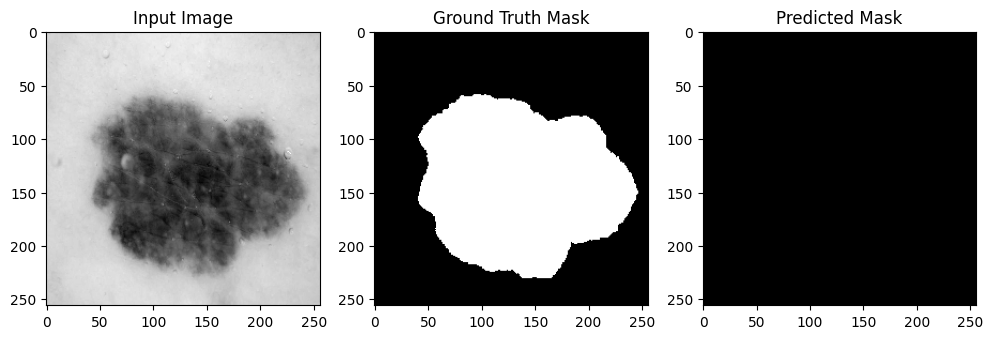

In [41]:
# Hiển thị một ảnh và mặt nạ thực tế cùng với dự đoán của mô hình
index = 50  # Chọn chỉ số của một ảnh trong tập validation
plt.figure(figsize=(12, 6))

# Ảnh gốc
plt.subplot(1, 3, 1)
plt.imshow(X_val[index].squeeze(), cmap='gray')
plt.title("Input Image")

# Mặt nạ thực tế
plt.subplot(1, 3, 2)
plt.imshow(Y_val[index].squeeze(), cmap='gray')
plt.title("Ground Truth Mask")

# Dự đoán
plt.subplot(1, 3, 3)
plt.imshow(predictions[index].squeeze(), cmap='gray')
plt.title("Predicted Mask")

plt.show()

## ResNet + U-Net

In [33]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, UpSampling2D, Activation
)

def resnet_unet(input_shape=(256, 256, 1)):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Pretrained ResNet encoder (transfer learning)
    resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Concatenate()([inputs, inputs, inputs]))
    encoder_layers = [
        resnet.get_layer(name).output
        for name in ["conv1_relu", "conv2_block3_out", "conv3_block4_out", "conv4_block6_out"]
    ]
    
    # Decoder layers (U-Net style)
    def decoder_block(input_tensor, skip_tensor, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)
        x = concatenate([x, skip_tensor])
        x = Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
        x = Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
        return x

    # Construct decoder blocks
    d4 = decoder_block(encoder_layers[3], encoder_layers[2], 256)
    d3 = decoder_block(d4, encoder_layers[1], 128)
    d2 = decoder_block(d3, encoder_layers[0], 64)
    
    d2_up = UpSampling2D(size=(2, 2))(d2)
    
    # Final convolution layer
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(d2_up)
    
    # Create model
    model = models.Model(inputs, outputs)
    return model

In [34]:
model = resnet_unet(input_shape=(256, 256, 1))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ input_layer_3[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_3[0]… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ concatenate[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 12,862,721 (49.07 MB)

 Trainable params: 12,832,129 (48.95 MB)

 Non-trainable params: 30,592 (119.50 KB)

In [35]:
model.compile(optimizer="adam", loss=dice_loss, metrics=['accuracy', dice_coefficient])
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, batch_size=16)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 316s 5s/step - accuracy: 0.7859 - dice_coefficient: 0.6795 - loss: 0.3205 - val_accuracy: 0.7442 - val_dice_coefficient: 3.9986e-12 - val_loss: 1.0000
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 275s 5s/step - accuracy: 0.9274 - dice_coefficient: 0.8667 - loss: 0.1332 - val_accuracy: 0.7442 - val_dice_coefficient: 3.9986e-12 - val_loss: 1.0000
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.9328 - dice_coefficient: 0.8785 - loss: 0.1215 - val_accuracy: 0.7442 - val_dice_coefficient: 3.9986e-12 - val_loss: 1.0000
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.9307 - dice_coefficient: 0.8755 - loss: 0.1244 - val_accuracy: 0.7442 - val_dice_coefficient: 4.0201e-12 - val_loss: 1.0000
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.9359 - dice_coefficient: 0.8856 - loss: 0.1144 - val_accuracy: 0.7442 - val_dice_coefficient: 7.2564e-12 - val_loss: 1.0000
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 282s 5s/step - ac

In [36]:
results = model.evaluate(X_val, Y_val, batch_size=16)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Dice Coefficient: {results[2]:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8940 - dice_coefficient: 0.7474 - loss: 0.2525
Validation Loss: 0.2646
Validation Dice Coefficient: 0.7343


In [37]:
predictions = model.predict(X_val)

7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step


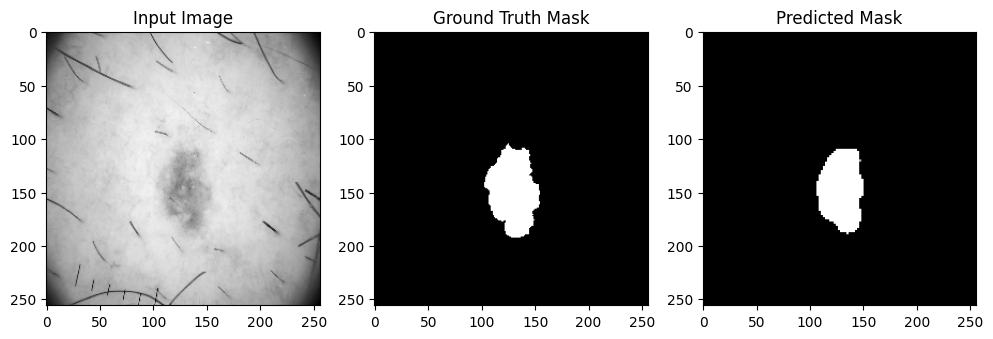

In [38]:
# Hiển thị một ảnh và mặt nạ thực tế cùng với dự đoán của mô hình
index = 102  # Chọn chỉ số của một ảnh trong tập validation
plt.figure(figsize=(12, 6))

# Ảnh gốc
plt.subplot(1, 3, 1)
plt.imshow(X_val[index].squeeze(), cmap='gray')
plt.title("Input Image")

# Mặt nạ thực tế
plt.subplot(1, 3, 2)
plt.imshow(Y_val[index].squeeze(), cmap='gray')
plt.title("Ground Truth Mask")

# Dự đoán
plt.subplot(1, 3, 3)
plt.imshow(predictions[index].squeeze(), cmap='gray')
plt.title("Predicted Mask")

plt.show()

In [42]:
model.save('ResUNet.h5')

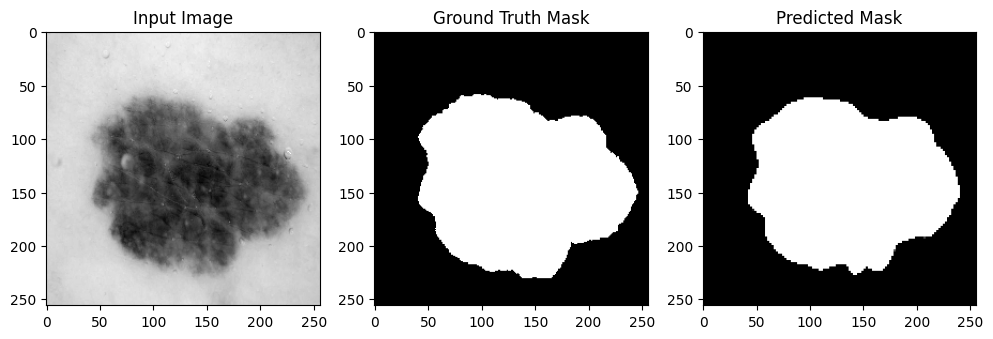

In [43]:
# Hiển thị một ảnh và mặt nạ thực tế cùng với dự đoán của mô hình
index = 50  # Chọn chỉ số của một ảnh trong tập validation
plt.figure(figsize=(12, 6))

# Ảnh gốc
plt.subplot(1, 3, 1)
plt.imshow(X_val[index].squeeze(), cmap='gray')
plt.title("Input Image")

# Mặt nạ thực tế
plt.subplot(1, 3, 2)
plt.imshow(Y_val[index].squeeze(), cmap='gray')
plt.title("Ground Truth Mask")

# Dự đoán
plt.subplot(1, 3, 3)
plt.imshow(predictions[index].squeeze(), cmap='gray')
plt.title("Predicted Mask")

plt.show()